In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

import os
import shutil

Mounted at /content/drive


In [3]:
import os
import scipy.io
import numpy as np
import pandas as pd
import glob
import pywt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.stats import iqr
import seaborn as sns
from imblearn.over_sampling import SMOTE
from scipy.stats import shapiro, f_oneway

In [4]:
# Ruta a los datos en Google Drive
data_dir = '/content/drive/My Drive/cpsc_2018'

# Función para leer el archivo .hea y obtener el diagnóstico
def read_hea(file_path):
    with open(file_path, 'r') as file:
        hea_content = file.readlines()
    diagnosis_line = next(line for line in hea_content if line.startswith('# Dx:'))
    diagnosis_code = diagnosis_line.split(': ')[1].strip()
    return diagnosis_code

# Función para procesar los archivos .mat y .hea
def process_files(directory):
    X, y = [], []
    for filename in os.listdir(directory):
        if filename.endswith('.mat'):
            mat_path = os.path.join(directory, filename)

            # Buscar el archivo .hea correspondiente
            hea_files = glob.glob(mat_path.replace('.mat', '*.hea'))
            if not hea_files:
                continue  # Saltar si no se encuentra un archivo .hea

            hea_path = hea_files[0]

            # Leer el archivo .mat
            mat_data = scipy.io.loadmat(mat_path)
            ecg_signals = mat_data['val']

            # Extraer solo la segunda derivación
            second_lead = ecg_signals[1]

            # Leer el archivo .hea para obtener el diagnóstico
            diagnosis_code = read_hea(hea_path)

            # Agregar la segunda derivación y el diagnóstico a las listas
            X.append(second_lead)
            y.append(diagnosis_code)

    # Encontrar la longitud mínima en esta carpeta
    min_length = min(len(signal) for signal in X)

    # Asegurarse de que todas las señales tengan la longitud mínima
    X = np.array([signal[:min_length] for signal in X])
    y = np.array(y)
    return X, y

# Procesar archivos en todas las carpetas g1 a g7
all_X, all_y = [], []
for folder in ['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7']:
    folder_path = os.path.join(data_dir, folder)
    X, y = process_files(folder_path)
    all_X.append(X)
    all_y.append(y)

# Encontrar la longitud mínima global entre todas las carpetas
global_min_length = min(X.shape[1] for X in all_X)

# Recortar todas las señales a la longitud mínima global
all_X = [X[:, :global_min_length] for X in all_X]

# Concatenar todos los datos
all_X = np.concatenate(all_X, axis=0)
all_y = np.concatenate(all_y, axis=0)

Diferenciamos pacientes con fibrilacion auricular y pacientes sanos

In [6]:
# Obtener los valores únicos en all_y
unique_labels = np.unique(all_y)

# Mostrar los valores únicos
print("Valores únicos en all_y:")
print(unique_labels)

Valores únicos en all_y:
['164884008' '164884008,164931005' '164884008,429622005' '164889003'
 '164889003,164884008' '164889003,164909002'
 '164889003,164909002,429622005' '164889003,164931005'
 '164889003,284470004' '164889003,429622005' '164889003,59118001'
 '164909002' '164909002,164884008' '164909002,164931005'
 '164909002,284470004' '164931005' '270492004' '270492004,164884008'
 '270492004,164909002' '270492004,164931005' '270492004,284470004'
 '270492004,429622005' '270492004,59118001' '284470004'
 '284470004,164884008' '284470004,164931005' '284470004,429622005'
 '426783006' '429622005' '429622005,164931005' '59118001'
 '59118001,164884008' '59118001,164931005' '59118001,284470004'
 '59118001,284470004,164931005' '59118001,429622005']


###Clasificación de ritmo sinusal y fibrilación auricular


In [7]:
# Identificar las etiquetas correspondientes
af_code = '164889003'
healthy_code = '426783006'

# Función para filtrar y reetiquetar los diagnósticos
def filter_and_label_data(X, y, af_code, healthy_code):
    filtered_X, filtered_y = [], []
    for signal, diagnosis in zip(X, y):
        if af_code in diagnosis and healthy_code in diagnosis:
            continue  # Ignorar si ambos códigos están presentes
        elif af_code in diagnosis:
            filtered_X.append(signal)
            filtered_y.append(1)  # Etiqueta para AF
        elif healthy_code in diagnosis:
            filtered_X.append(signal)
            filtered_y.append(0)  # Etiqueta para sano

    return np.array(filtered_X), np.array(filtered_y)

# Filtrar y reetiquetar los datos
filtered_X, filtered_y = filter_and_label_data(all_X, all_y, af_code, healthy_code)

In [8]:
# Obtener los valores únicos en all_y
unique_labels_filtrados = np.unique(filtered_y)

# Mostrar los valores únicos
print("Valores únicos en all_y filtrados:")
print(unique_labels_filtrados)

Valores únicos en all_y filtrados:
[0 1]


In [9]:
# Mostrar las formas de los datos filtrados
print(f'Datos filtrados: {filtered_X.shape}, Etiquetas filtradas: {filtered_y.shape}')

Datos filtrados: (2139, 3000), Etiquetas filtradas: (2139,)


De esto, la etiqueta para sano fue asignado como 0, y la etiqueta para un paciente con fibrilación auricular es 1.

Con esto, se puede realizar el machine learning asociado al AF.

Consideramos que los datos que han sido filtrados y las etiquetas corresponden al mismo nivel, es decir para la primera fila de datos en filtered_X corresponde al primer valor de filtered_y.

###Preprocesamiento

In [10]:
# Función para calcular el nivel de descomposición adecuado
def get_max_wavelet_decomposition_level(signal_length, filter_length):
    return pywt.dwt_max_level(signal_length, filter_length)

# Preprocesamiento con Wavelet Transform
def preprocess_signal_with_dwt(signal, wavelet='db6'):
    filter_length = pywt.Wavelet(wavelet).dec_len
    max_level = get_max_wavelet_decomposition_level(len(signal), filter_length)
    coeffs = pywt.wavedec(signal, wavelet, level=max_level)
    # Eliminar coeficientes no informativos
    if len(coeffs) > 1:
        coeffs[1] = np.zeros_like(coeffs[1])  # D1
    if len(coeffs) > 2:
        coeffs[2] = np.zeros_like(coeffs[2])  # D2
    coeffs[0] = np.zeros_like(coeffs[0])  # A_max_level
    cleaned_signal = pywt.waverec(coeffs, wavelet)
    return cleaned_signal

# Aplicar DWT a cada señal
filtered_X_dwt = np.array([preprocess_signal_with_dwt(signal) for signal in filtered_X])


El código calcula el nivel de descomposición adecuado y para el preprocesamiento de la señal usando Wavelet Transform. Inicialmente según el paper  el preprocesamiento de la señal ECG con la Transformada Wavelet Discreta utilizando la wavelet Daubechies 6 (db6), la eliminación de ruido en los coeficientes de detalle D1, D2 y la aproximación A10. Pero el nivel de descomposición (10) es demasiado alto para la longitud de las señales, lo que puede causar efectos de borde. Podemos reducir el nivel de descomposición para evitar este problema y ajustarnos a la longitud de las señales.

###Análisis de datos

Forma de la señal del paciente sano antes del Preprocesamiento wavelt: (3000,)
Forma de la señal del paciente con AF antes del Preprocesamiento wavelt: (3000,)
Forma de la señal del paciente sano después del Preprocesamiento wavelt: (3000,)
Forma de la señal del paciente con AF después del Preprocesamiento wavelt: (3000,)


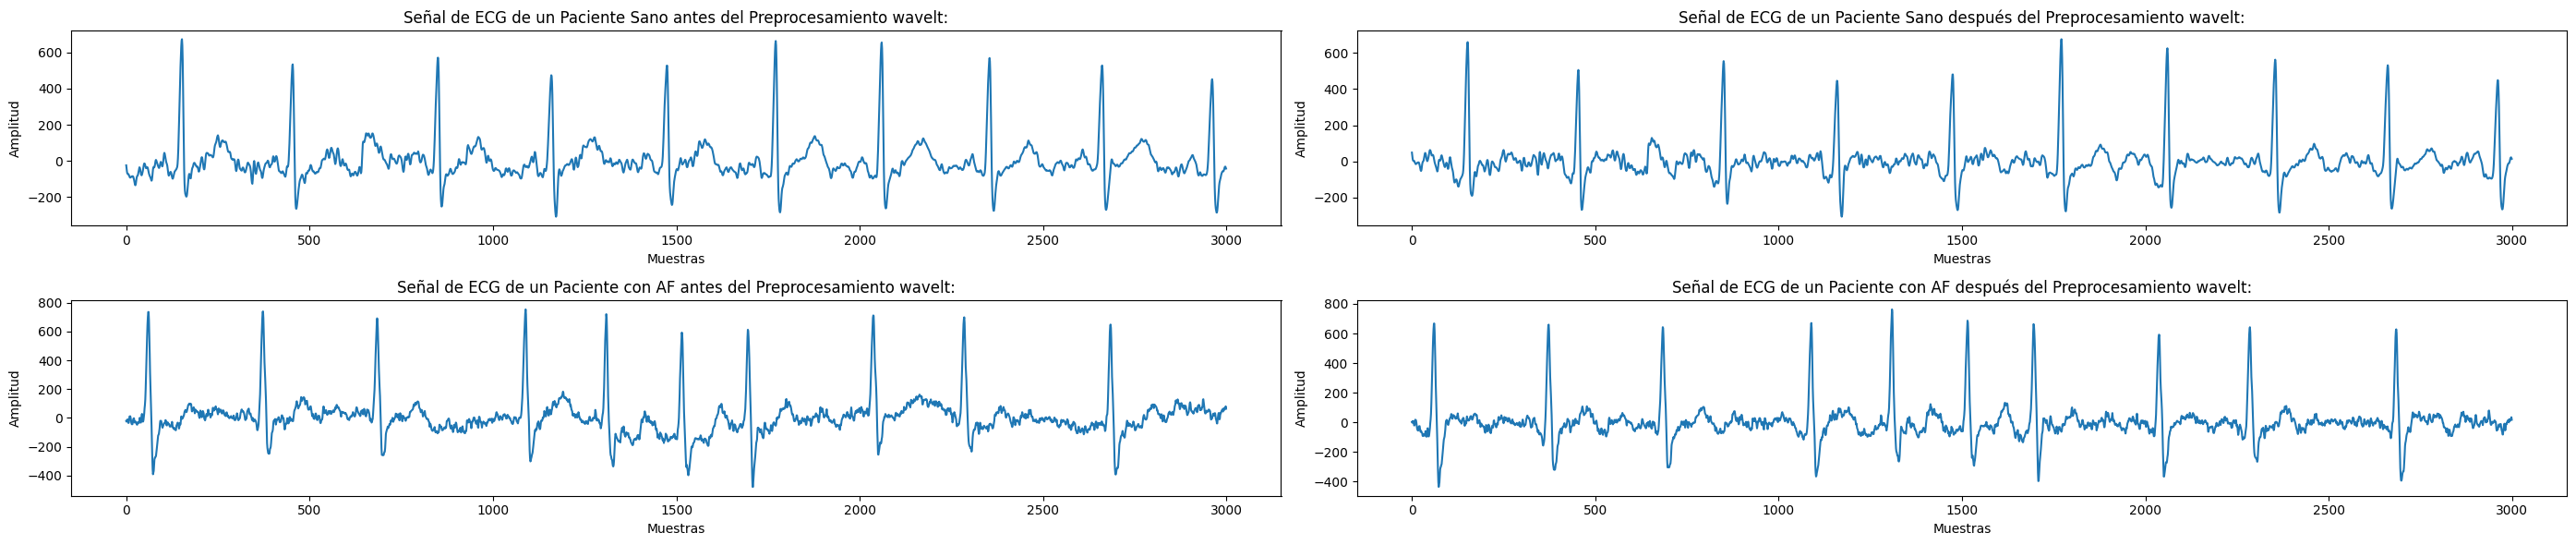

In [11]:

# Un ejemplo de paciente sano y un ejemplo de AF antes del Preprocesamiento wavelt
healthy_example_1 = filtered_X[filtered_y == 0][0]
af_example_1 = filtered_X[filtered_y == 1][0]

# Un ejemplo de paciente sano y un ejemplo de AF después del Preprocesamiento wavelt
healthy_example_2 = filtered_X_dwt[filtered_y == 0][0]
af_example_2 = filtered_X_dwt[filtered_y == 1][0]

# Imprimir la forma de las señales
print("Forma de la señal del paciente sano antes del Preprocesamiento wavelt:", healthy_example_1.shape)
print("Forma de la señal del paciente con AF antes del Preprocesamiento wavelt:", af_example_1.shape)
print("Forma de la señal del paciente sano después del Preprocesamiento wavelt:", healthy_example_2.shape)
print("Forma de la señal del paciente con AF después del Preprocesamiento wavelt:", af_example_2.shape)

# Plotear las señales
plt.figure(figsize=(28, 6))

plt.subplot(2, 2, 1)
plt.plot(healthy_example_1)
plt.title('Señal de ECG de un Paciente Sano antes del Preprocesamiento wavelt:')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

plt.subplot(2, 2, 2)
plt.plot(healthy_example_2)
plt.title('Señal de ECG de un Paciente Sano después del Preprocesamiento wavelt:')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

plt.subplot(2, 2, 3)
plt.plot(af_example_1)
plt.title('Señal de ECG de un Paciente con AF antes del Preprocesamiento wavelt:')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

plt.subplot(2, 2, 4)
plt.plot(af_example_2)
plt.title('Señal de ECG de un Paciente con AF después del Preprocesamiento wavelt:')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()

In [12]:
# Función para detectar picos R y calcular los intervalos R-R
def calculate_rr_intervals(signal, fs=500):
    peaks, _ = find_peaks(signal, distance=fs/2)  # suponer que la frecuencia cardíaca no es mayor a 150 bpm
    rr_intervals = np.diff(peaks) / fs  # intervalos R-R en segundos
    return rr_intervals

# Función para calcular la media móvil
def running_mean(rr_intervals):
    rmean = np.zeros(len(rr_intervals))
    rmean[0] = rr_intervals[0]
    for i in range(1, len(rr_intervals)):
        rmean[i] = 0.75 * rmean[i-1] + 0.25 * rr_intervals[i]
    return rmean

# Función para clasificar los intervalos R-R
def classify_rr_intervals(rr_intervals, rmean):
    classifications = np.zeros(len(rr_intervals))
    for i in range(len(rr_intervals)):
        if rr_intervals[i] < 0.85 * rmean[i]:
            classifications[i] = 0  # Corto
        elif rr_intervals[i] > 1.15 * rmean[i]:
            classifications[i] = 2  # Largo
        else:
            classifications[i] = 1  # Regular
    return classifications

# Función para generar las características de la matriz de transición
def generate_transition_matrix_features(rr_intervals):
    if len(rr_intervals) < 2:
        return np.zeros(9)

    rmean = running_mean(rr_intervals)
    classifications = classify_rr_intervals(rr_intervals, rmean)

    transition_matrix = np.zeros((3, 3))
    for i in range(len(classifications) - 1):
        current_class = int(classifications[i])
        next_class = int(classifications[i + 1])
        transition_matrix[current_class, next_class] += 1

    transition_matrix = transition_matrix.flatten()
    return transition_matrix

# Función para calcular RRvar
def calculate_rrvar(rr_intervals):
    return np.mean(np.abs(np.diff(rr_intervals)) / np.mean(rr_intervals))

# Función para calcular RR200
def calculate_rr200(rr_intervals):
    return np.sum(np.abs(np.diff(rr_intervals)) > 0.2)

# Función para calcular RMS
def calculate_rms(rr_intervals):
    return np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

# Función para calcular σRR
def calculate_std_rr(rr_intervals):
    return np.std(rr_intervals)

# Función para calcular MAD
def calculate_mad(rr_intervals):
    return np.median(np.abs(rr_intervals - np.median(rr_intervals)))

# Función para calcular CoefVar
def calculate_coefvar(rr_intervals):
    return np.std(rr_intervals) / np.mean(rr_intervals)

# Función para calcular IQR
def calculate_iqr(rr_intervals):
    return iqr(rr_intervals)

# Función para calcular Range
def calculate_range(rr_intervals):
    return np.max(rr_intervals) - np.min(rr_intervals)

# Función para calcular el Gini Index
def calculate_gini(rr_intervals):
    rr_intervals_sorted = np.sort(rr_intervals)
    n = len(rr_intervals)
    cumulative_sum = np.cumsum(rr_intervals_sorted)
    return (2 / n) * np.sum((np.arange(1, n+1) - cumulative_sum / np.sum(rr_intervals_sorted))) / n

# Función para extraer todas las características
def extract_features(signal):
    rr_intervals = calculate_rr_intervals(signal)
    features = []
    features.extend(generate_transition_matrix_features(rr_intervals))
    features.append(calculate_rrvar(rr_intervals))
    features.append(calculate_rr200(rr_intervals))
    features.append(calculate_rms(rr_intervals))
    features.append(calculate_std_rr(rr_intervals))
    features.append(calculate_mad(rr_intervals))
    features.append(calculate_coefvar(rr_intervals))
    features.append(calculate_iqr(rr_intervals))
    features.append(calculate_range(rr_intervals))
    features.append(calculate_gini(rr_intervals))
    return features

# Generar los nombres de las características
def generate_feature_names(bins=10):
    states = ['Short', 'Regular', 'Long']
    feature_names = [f'{from_state}to{to_state}' for from_state in states for to_state in states]
    feature_names.append('RRvar')
    feature_names.append('RR200')
    feature_names.append('RMS')
    feature_names.append('StdRR')
    feature_names.append('MAD')
    feature_names.append('CoefVar')
    feature_names.append('IQR')
    feature_names.append('Range')
    feature_names.append('Gini')
    return feature_names

# Aplicar la extracción de características a todas las señales en filtered_X_dwt
all_features = [extract_features(signal) for signal in filtered_X_dwt]

# Convertir las características a un array de NumPy
features = np.array(all_features)

# Añadimos etiquetas de los resultados si tienen AF o son sanos
labels = np.array(filtered_y)

# Generar los nombres de las características
feature_names = generate_feature_names()

# Convertir a un DataFrame de pandas para una mejor visualización
import pandas as pd

df_features = pd.DataFrame(features, columns=feature_names)

# Mostrar el DataFrame
print(df_features.head())


   ShorttoShort  ShorttoRegular  ShorttoLong  RegulartoShort  \
0           0.0             0.0          0.0             0.0   
1           0.0             0.0          0.0             1.0   
2           0.0             0.0          0.0             0.0   
3           3.0             0.0          0.0             0.0   
4           0.0             0.0          1.0             1.0   

   RegulartoRegular  RegulartoLong  LongtoShort  LongtoRegular  LongtoLong  \
0               6.0            1.0          0.0            1.0         0.0   
1               1.0            1.0          0.0            1.0         2.0   
2               4.0            2.0          1.0            1.0         0.0   
3               0.0            1.0          1.0            0.0         2.0   
4               3.0            0.0          0.0            1.0         1.0   

      RRvar  RR200       RMS     StdRR    MAD   CoefVar     IQR  Range  \
0  0.096120    0.0  0.092590  0.061315  0.014  0.098226  0.0260  0.214  

In [13]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ShorttoShort      2139 non-null   float64
 1   ShorttoRegular    2139 non-null   float64
 2   ShorttoLong       2139 non-null   float64
 3   RegulartoShort    2139 non-null   float64
 4   RegulartoRegular  2139 non-null   float64
 5   RegulartoLong     2139 non-null   float64
 6   LongtoShort       2139 non-null   float64
 7   LongtoRegular     2139 non-null   float64
 8   LongtoLong        2139 non-null   float64
 9   RRvar             2139 non-null   float64
 10  RR200             2139 non-null   float64
 11  RMS               2139 non-null   float64
 12  StdRR             2139 non-null   float64
 13  MAD               2139 non-null   float64
 14  CoefVar           2139 non-null   float64
 15  IQR               2139 non-null   float64
 16  Range             2139 non-null   float64


###Análisis de features (EDA)

       ShorttoShort  ShorttoRegular  ShorttoLong  RegulartoShort  \
count   2139.000000     2139.000000  2139.000000     2139.000000   
mean       0.216456        0.343151     0.100047        0.522674   
std        0.594951        0.629092     0.321210        0.734570   
min        0.000000        0.000000     0.000000        0.000000   
25%        0.000000        0.000000     0.000000        0.000000   
50%        0.000000        0.000000     0.000000        0.000000   
75%        0.000000        1.000000     0.000000        1.000000   
max        5.000000        3.000000     2.000000        4.000000   

       RegulartoRegular  RegulartoLong  LongtoShort  LongtoRegular  \
count       2139.000000    2139.000000  2139.000000    2139.000000   
mean           3.914446       0.721833     0.128565       0.594670   
std            2.271899       0.772992     0.360364       0.674117   
min            0.000000       0.000000     0.000000       0.000000   
25%            2.000000       0.00000

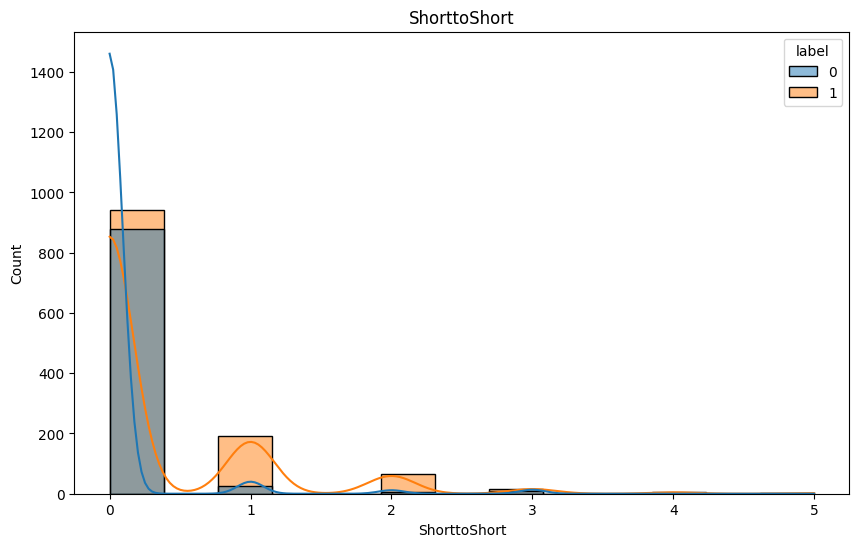

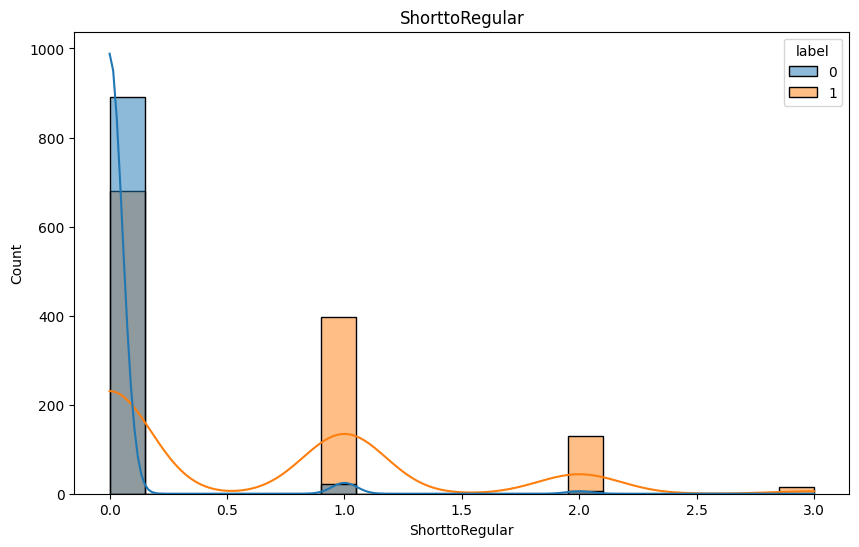

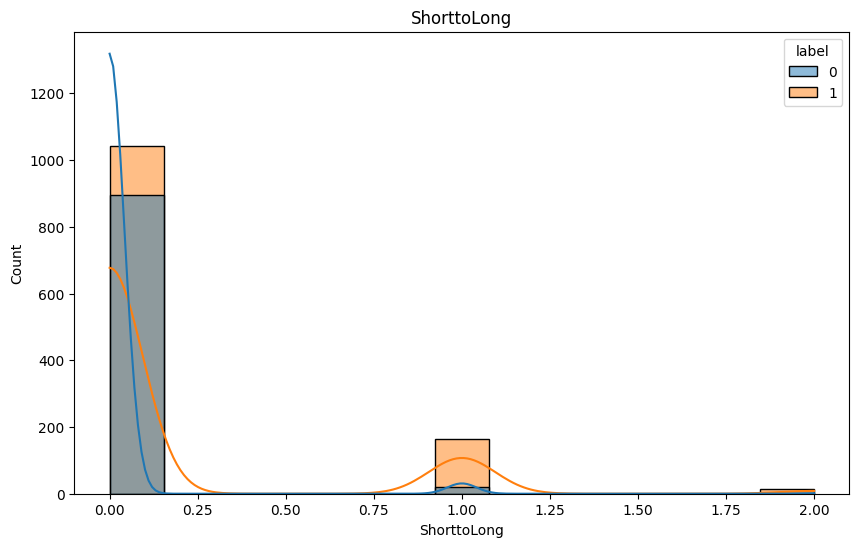

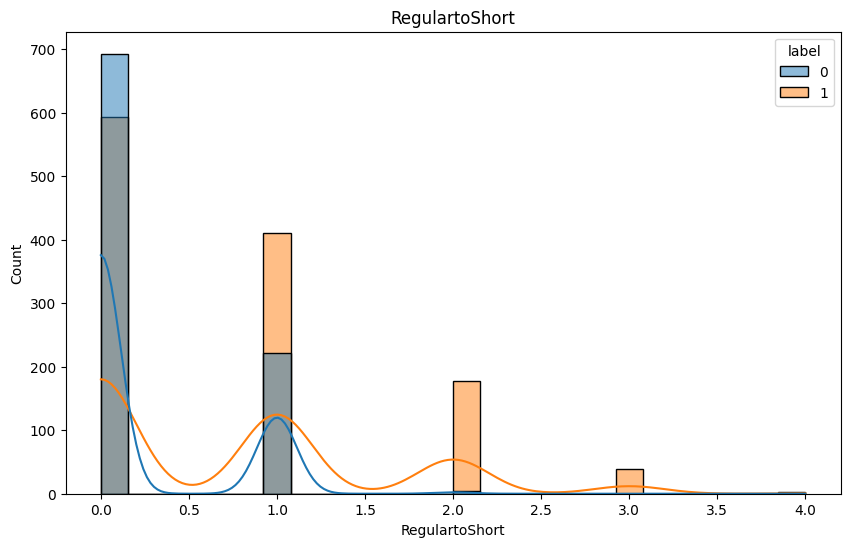

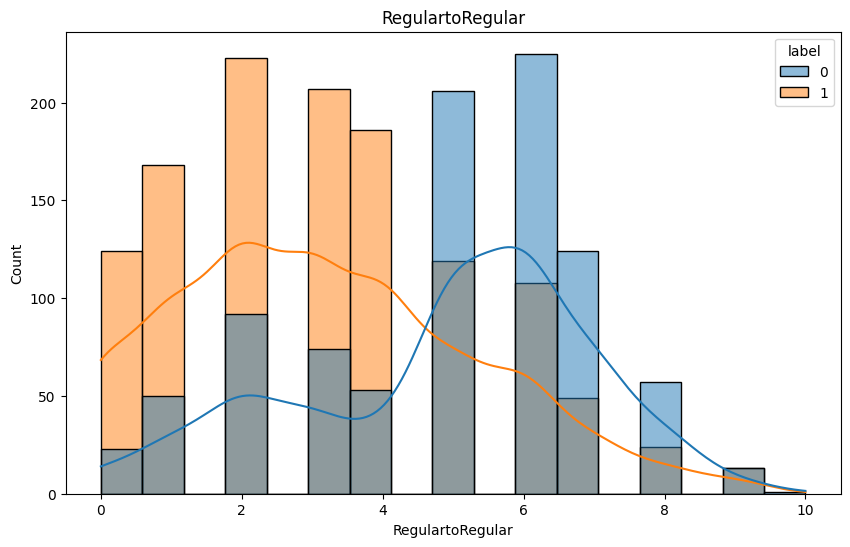

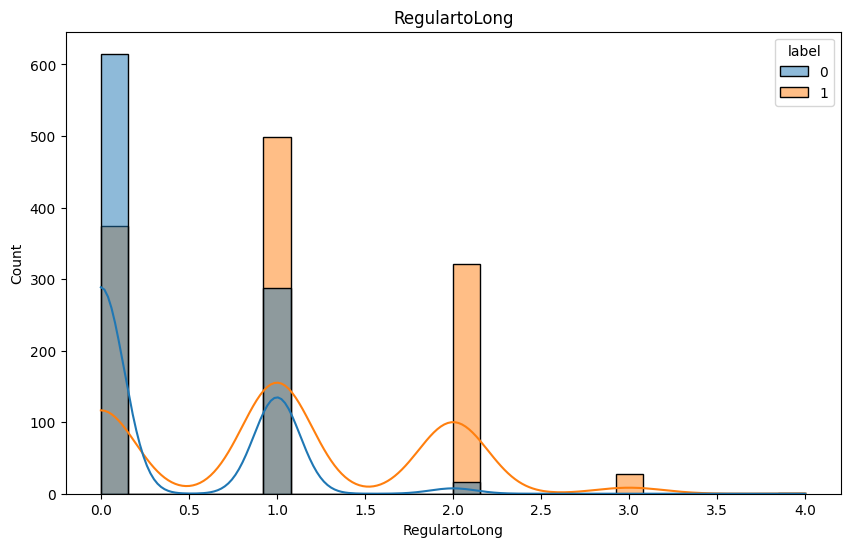

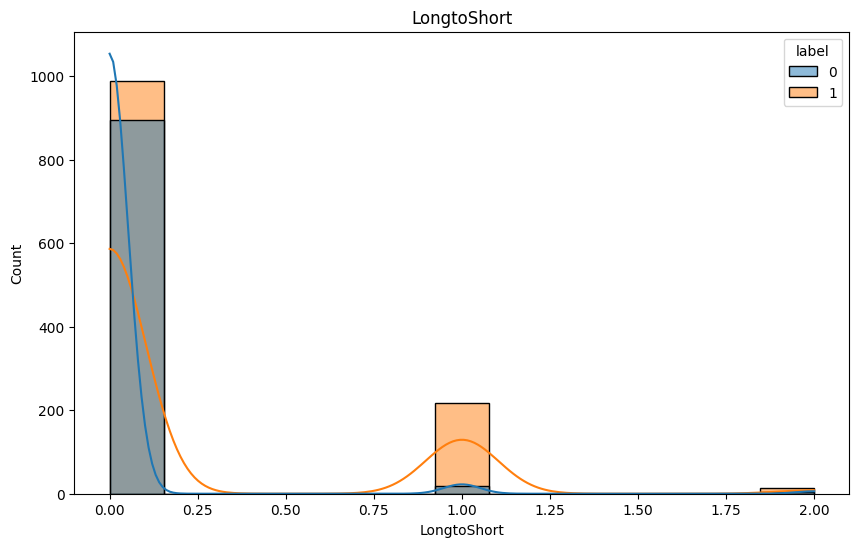

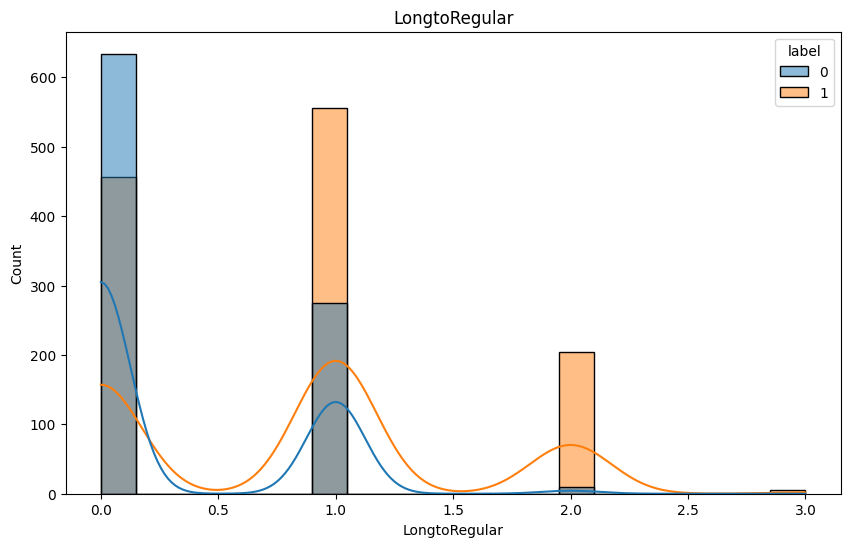

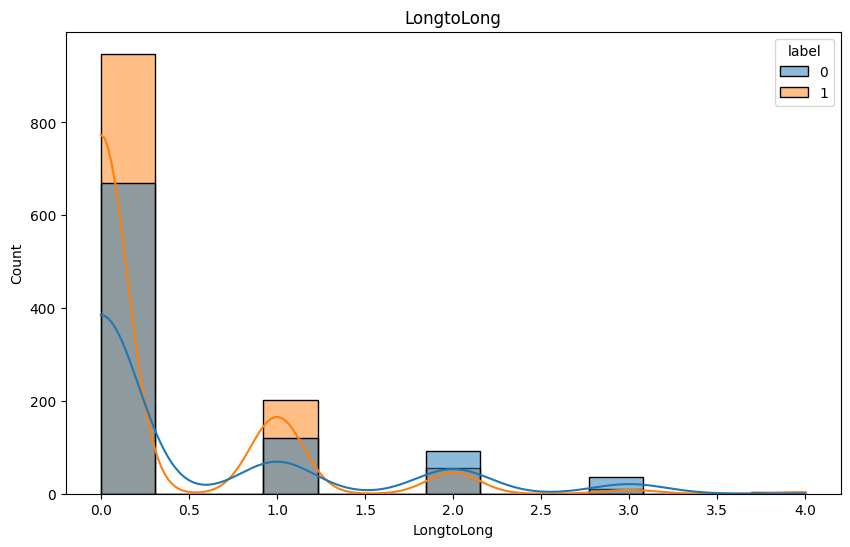

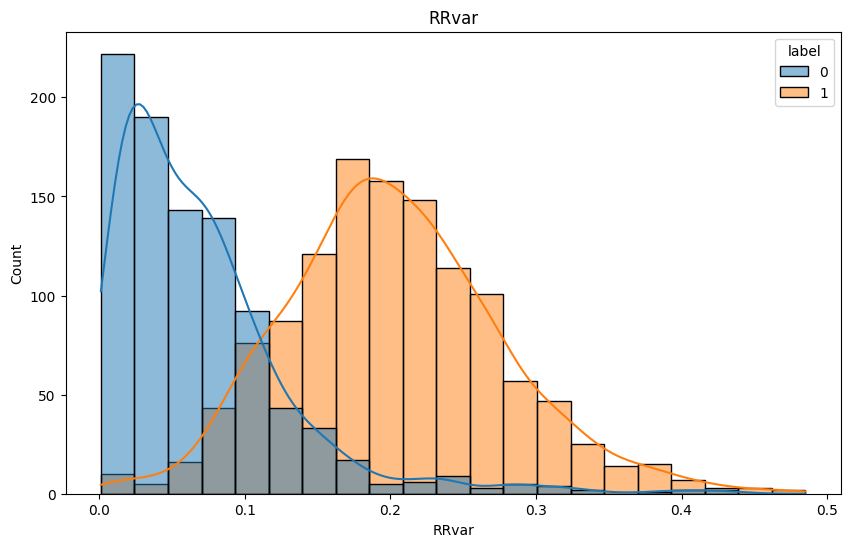

In [14]:
# Convertir las características y etiquetas en un DataFrame de pandas para facilitar el análisis
df = pd.DataFrame(features, columns=feature_names)
df['label'] = labels

# Imprimir estadísticas descriptivas
print(df.describe())

# Graficar distribuciones de las primeras características para cada clase
for i in range(10):  # Graficar solo las primeras 10 características por simplicidad
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature_names[i], hue='label', kde=True)
    plt.title(feature_names[i])
    plt.show()

Según bibliografía, utilizar todos los features de la matriz de transición introduciría colinealidad al modelo, debido a que la suma de porcentajes de todas las transiciones es 1. Para evitar esto, se decidió dropear 'RtoR' debido a predominar en la mayoría de los datos, y así mantenern la diversidad de las demás características.

In [15]:
df.drop('RegulartoRegular', axis=1, inplace=True)

###Eliminamos valores atípicos

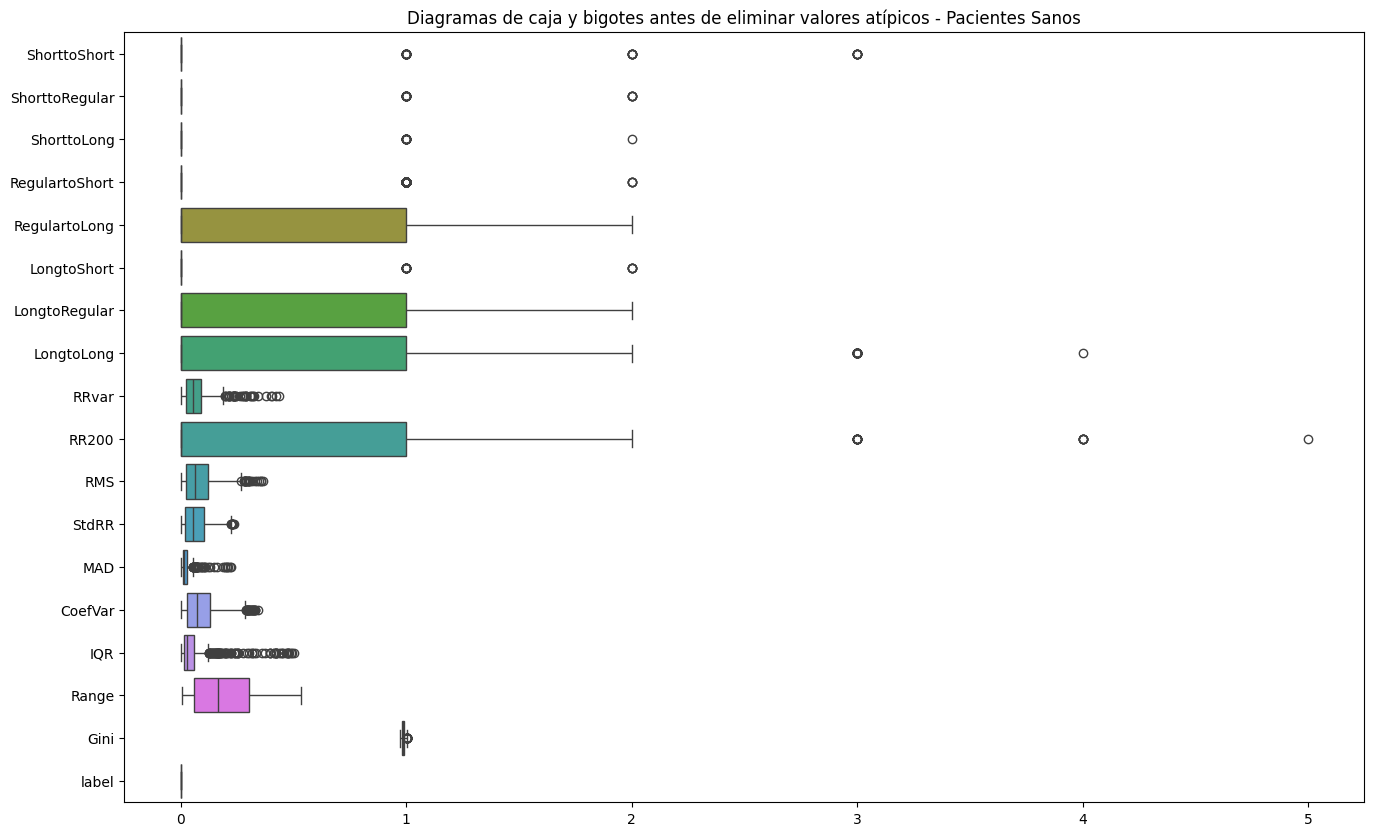

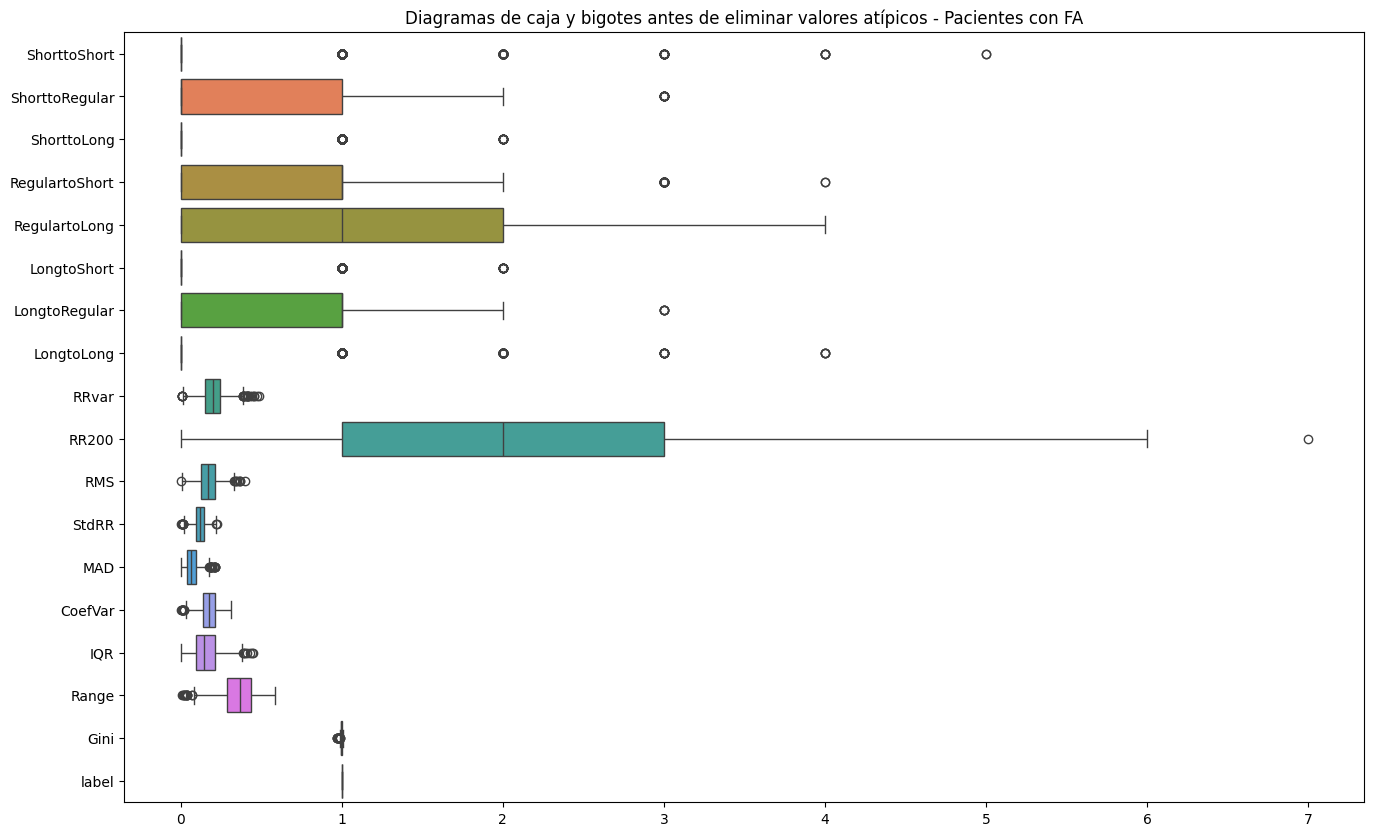

In [16]:
# Separar por pacientes sanos y pacientes con fibrilación auricular
df_healthy = df[labels == 0]
df_af = df[labels == 1]

# Crear diagramas de caja y bigotes antes de eliminar valores atípicos
plt.figure(figsize=(16, 10))
plt.title("Diagramas de caja y bigotes antes de eliminar valores atípicos - Pacientes Sanos")
sns.boxplot(data=df_healthy, orient="h")
plt.show()

plt.figure(figsize=(16, 10))
plt.title("Diagramas de caja y bigotes antes de eliminar valores atípicos - Pacientes con FA")
sns.boxplot(data=df_af, orient="h")
plt.show()


Vemos que para las características 'ShorttoShort', 'ShorttoLong' y 'LongtoShort' no varía de cero excepto para valores atípicos, por lo que decidimos eliminar esas filas de ambos dataframe.

In [17]:
df_healthy = df_healthy.drop(['ShorttoShort', 'ShorttoLong', 'LongtoShort'], axis=1)
df_af = df_af.drop(['ShorttoShort', 'ShorttoLong', 'LongtoShort'], axis=1)

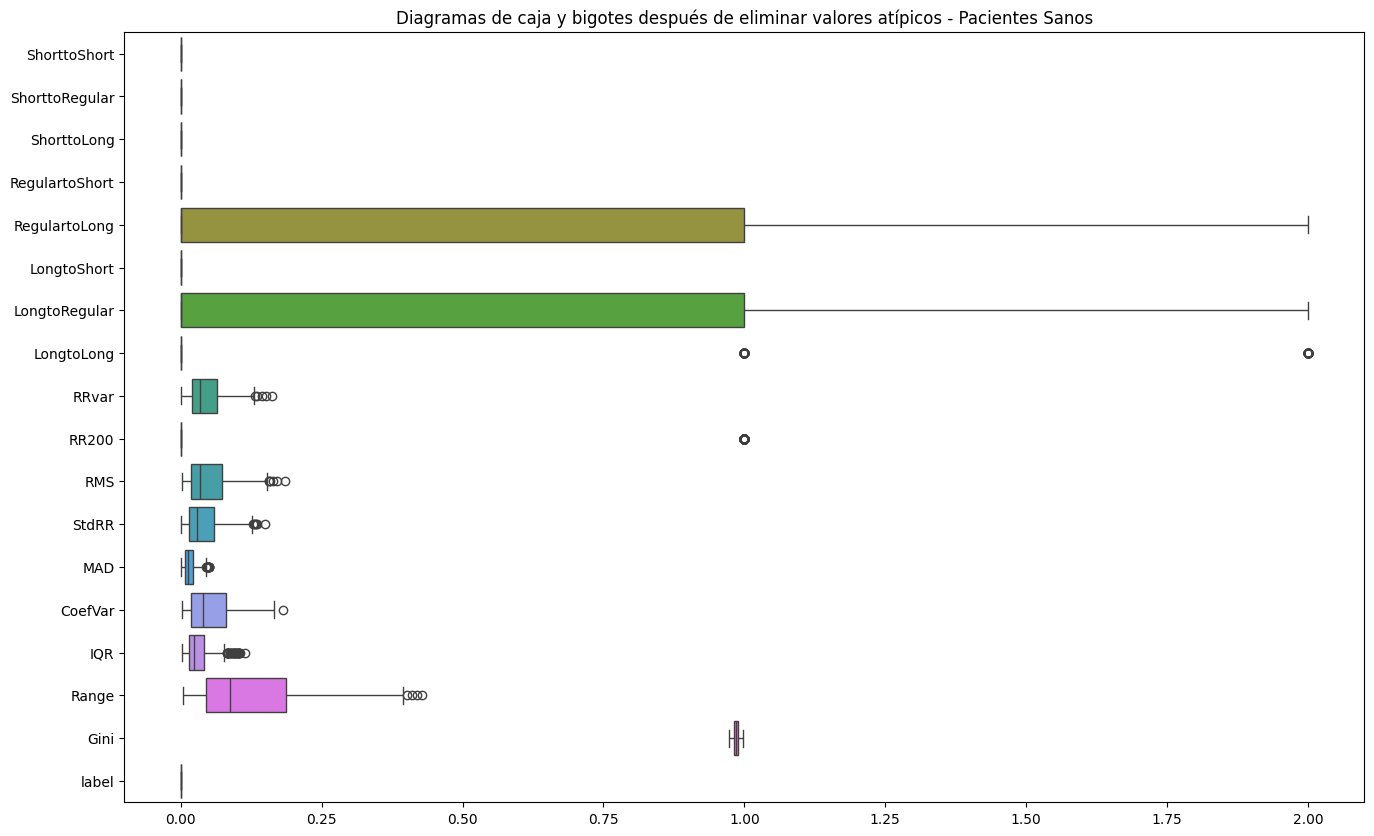

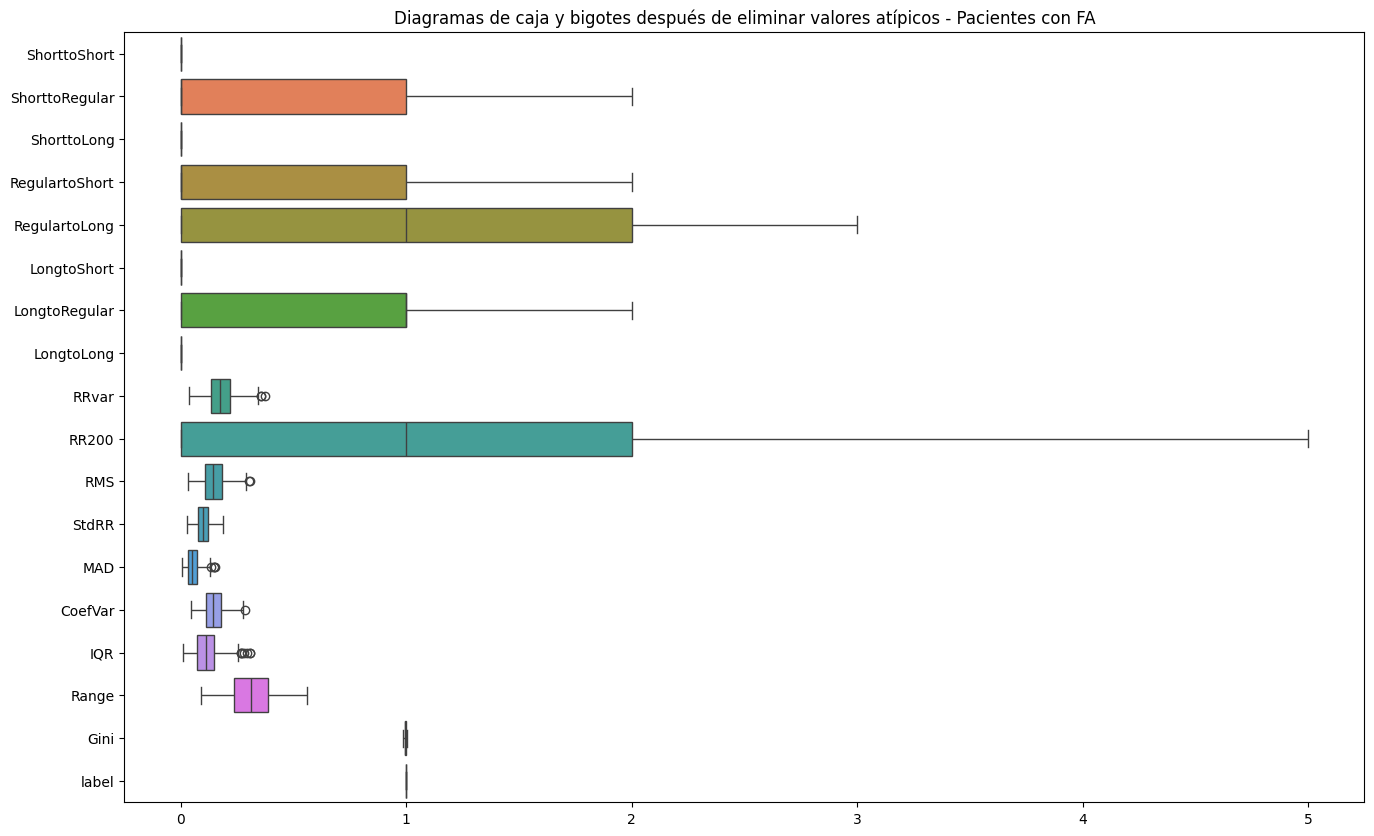

In [39]:
# Función para identificar y eliminar valores atípicos por fila
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    filter = (df >= (Q1 - 1.5 * IQR)) & (df <= (Q3 + 1.5 * IQR))
    return df[filter.all(axis=1)]

# Remover los valores atípicos
clean_df_healthy = remove_outliers(df_healthy)
clean_df_af = remove_outliers(df_af)

# Crear diagramas de caja y bigotes después de eliminar valores atípicos
plt.figure(figsize=(16, 10))
plt.title("Diagramas de caja y bigotes después de eliminar valores atípicos - Pacientes Sanos")
sns.boxplot(data=clean_df_healthy, orient="h")
plt.show()

plt.figure(figsize=(16, 10))
plt.title("Diagramas de caja y bigotes después de eliminar valores atípicos - Pacientes con FA")
sns.boxplot(data=clean_df_af, orient="h")
plt.show()

# Combinar los datos limpios
clean_df_features = pd.concat([clean_df_healthy, clean_df_af])
clean_labels = np.concatenate([np.zeros(len(clean_df_healthy)), np.ones(len(clean_df_af))])

In [19]:
df_healthy = df[labels == 0]
df_af = df[labels == 1]

df_healthy.describe()

,ShorttoShort,ShorttoRegular,ShorttoLong,RegulartoShort,RegulartoLong,LongtoShort,LongtoRegular,LongtoLong,RRvar,RR200,RMS,StdRR,MAD,CoefVar,IQR,Range,Gini,label
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.0
mean,0.067538,0.034858,0.025054,0.249455,0.347495,0.031590,0.319172,0.453159,0.068829,0.543573,0.081374,0.066801,0.021331,0.087482,0.055646,0.194734,0.986558,0.0
std,0.361465,0.211152,0.163200,0.442895,0.511748,0.203791,0.486998,0.835085,0.060800,0.774285,0.069413,0.054422,0.024840,0.072247,0.080560,0.144745,0.006632,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001125,0.000000,0.001491,0.001327,0.000000,0.002238,0.000000,0.004000,0.972506,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025077,0.000000,0.023080,0.020555,0.008000,0.026377,0.016000,0.060500,0.982334,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055839,0.000000,0.062718,0.052726,0.014000,0.070270,0.030000,0.167000,0.986971,0.0
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.091955,1.000000,0.120955,0.101573,0.026000,0.130077,0.058000,0.304000,0.990179,0.0
max,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,0.434183,5.000000,0.363341,0.234902,0.224000,0.342887,0.502000,0.532000,1.005352,0.0


In [20]:
df_af.describe()

,ShorttoShort,ShorttoRegular,ShorttoLong,RegulartoShort,RegulartoLong,LongtoShort,LongtoRegular,LongtoLong,RRvar,RR200,RMS,StdRR,MAD,CoefVar,IQR,Range,Gini,label
count,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.0
mean,0.328419,0.574939,0.156429,0.728092,1.003276,0.201474,0.801802,0.295659,0.202268,1.886159,0.171005,0.119095,0.072590,0.174598,0.158476,0.354966,0.996306,1.0
std,0.702048,0.731265,0.391636,0.836526,0.815820,0.428911,0.719765,0.623493,0.074481,1.351737,0.061520,0.037558,0.039843,0.052535,0.082417,0.100432,0.004144,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005790,0.000000,0.004243,0.002455,0.001000,0.004061,0.004000,0.008000,0.972755,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153813,1.000000,0.129089,0.094403,0.042000,0.138979,0.096000,0.290000,0.994165,1.0
50%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.197924,2.000000,0.168723,0.122246,0.066000,0.178523,0.144500,0.370000,0.997010,1.0
75%,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000,0.246725,3.000000,0.210305,0.144741,0.095000,0.210749,0.210000,0.434000,0.999087,1.0
max,5.000000,3.000000,2.000000,4.000000,4.000000,2.000000,3.000000,4.000000,0.485115,7.000000,0.397645,0.225132,0.214000,0.312631,0.447500,0.584000,1.005040,1.0


In [38]:
clean_df_healthy.describe()

,ShorttoRegular,RegulartoShort,RegulartoLong,LongtoRegular,LongtoLong,RRvar,RR200,RMS,StdRR,MAD,CoefVar,IQR,Range,Gini,label
count,629.0,629.0,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.0
mean,0.0,0.0,0.271860,0.268680,0.321145,0.042792,0.211447,0.048870,0.040591,0.015574,0.052815,0.030293,0.124614,0.984103,0.0
std,0.0,0.0,0.452368,0.450748,0.652200,0.029939,0.408659,0.039867,0.032947,0.011110,0.041579,0.022285,0.101237,0.005473,0.0
min,0.0,0.0,0.000000,0.000000,0.000000,0.001125,0.000000,0.001491,0.001327,0.000000,0.002238,0.001500,0.004000,0.972506,0.0
25%,0.0,0.0,0.000000,0.000000,0.000000,0.019168,0.000000,0.017907,0.014422,0.007000,0.018256,0.014000,0.044000,0.980890,0.0
50%,0.0,0.0,0.000000,0.000000,0.000000,0.034624,0.000000,0.034256,0.028767,0.013000,0.038890,0.024000,0.088000,0.985249,0.0
75%,0.0,0.0,1.000000,1.000000,0.000000,0.064481,0.000000,0.073426,0.059664,0.022000,0.080091,0.041000,0.186000,0.988064,0.0
max,0.0,0.0,2.000000,2.000000,2.000000,0.161529,1.000000,0.185604,0.149235,0.051000,0.180603,0.114000,0.428000,0.997583,0.0


In [37]:
clean_df_af.describe()

,ShorttoRegular,RegulartoShort,RegulartoLong,LongtoRegular,LongtoLong,RRvar,RR200,RMS,StdRR,MAD,CoefVar,IQR,Range,Gini,label
count,853.000000,853.000000,853.000000,853.000000,853.0,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.0
mean,0.614302,0.757327,0.933177,0.767878,0.0,0.197707,1.764361,0.166209,0.112677,0.065532,0.166980,0.139798,0.345728,0.996026,1.0
std,0.690398,0.748054,0.810140,0.723547,0.0,0.066752,1.282620,0.057019,0.033971,0.034095,0.047777,0.070402,0.096899,0.003316,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0,0.037832,0.000000,0.032642,0.027640,0.004000,0.044028,0.010000,0.092000,0.986787,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.149157,1.000000,0.125974,0.087211,0.040000,0.131445,0.088000,0.276000,0.993955,1.0
50%,0.000000,1.000000,1.000000,1.000000,0.0,0.192553,2.000000,0.163913,0.114805,0.060000,0.168835,0.130000,0.354000,0.996416,1.0
75%,1.000000,1.000000,2.000000,1.000000,0.0,0.242863,3.000000,0.206159,0.137130,0.086000,0.204068,0.180000,0.428000,0.998516,1.0
max,2.000000,2.000000,3.000000,2.000000,0.0,0.385215,6.000000,0.313567,0.205156,0.174000,0.291415,0.376000,0.560000,1.003940,1.0


###Shapiro-Wilk

In [42]:
from scipy import stats

# Función para realizar la prueba de Shapiro-Wilk a todas las columnas
def shapiro_wilk_test(df):
    results = {}
    for column in df.columns:
        stat, p_value = stats.shapiro(df[column])
        results[column] = {'Estadístico': stat, 'Valor p': p_value}
    return results

# Realizar la prueba de Shapiro-Wilk para clean_df_healthy
shapiro_healthy = shapiro_wilk_test(clean_df_healthy)
print("Resultados de Shapiro-Wilk para clean_df_healthy:")
for column, result in shapiro_healthy.items():
    print(f"Columna: {column}")
    print(f"  Estadístico de la prueba: {result['Estadístico']}")
    print(f"  Valor p: {result['Valor p']}")
    alpha = 0.05
    if result['Valor p'] > alpha:
        print('  La muestra parece seguir una distribución normal (no se rechaza H0)')
    else:
        print('  La muestra no parece seguir una distribución normal (se rechaza H0)')
    print()

Resultados de Shapiro-Wilk para clean_df_healthy:
Columna: ShorttoShort
  Estadístico de la prueba: 1.0
  Valor p: 1.0
  La muestra parece seguir una distribución normal (no se rechaza H0)

Columna: ShorttoRegular
  Estadístico de la prueba: 1.0
  Valor p: 1.0
  La muestra parece seguir una distribución normal (no se rechaza H0)

Columna: ShorttoLong
  Estadístico de la prueba: 1.0
  Valor p: 1.0
  La muestra parece seguir una distribución normal (no se rechaza H0)

Columna: RegulartoShort
  Estadístico de la prueba: 1.0
  Valor p: 1.0
  La muestra parece seguir una distribución normal (no se rechaza H0)

Columna: RegulartoLong
  Estadístico de la prueba: 0.5643984079360962
  Valor p: 8.773244044458712e-37
  La muestra no parece seguir una distribución normal (se rechaza H0)

Columna: LongtoShort
  Estadístico de la prueba: 1.0
  Valor p: 1.0
  La muestra parece seguir una distribución normal (no se rechaza H0)

Columna: LongtoRegular
  Estadístico de la prueba: 0.5618646144866943
  Va

In [43]:
# Realizar la prueba de Shapiro-Wilk para clean_df_af
shapiro_af = shapiro_wilk_test(clean_df_af)
print("Resultados de Shapiro-Wilk para clean_df_af:")
for column, result in shapiro_af.items():
    print(f"Columna: {column}")
    print(f"  Estadístico de la prueba: {result['Estadístico']}")
    print(f"  Valor p: {result['Valor p']}")
    if result['Valor p'] > alpha:
        print('  La muestra parece seguir una distribución normal (no se rechaza H0)')
    else:
        print('  La muestra no parece seguir una distribución normal (se rechaza H0)')
    print()

Resultados de Shapiro-Wilk para clean_df_af:
Columna: ShorttoShort
  Estadístico de la prueba: 1.0
  Valor p: 1.0
  La muestra parece seguir una distribución normal (no se rechaza H0)

Columna: ShorttoRegular
  Estadístico de la prueba: 0.6620839834213257
  Valor p: 6.689120040501106e-31
  La muestra no parece seguir una distribución normal (se rechaza H0)

Columna: ShorttoLong
  Estadístico de la prueba: 1.0
  Valor p: 1.0
  La muestra parece seguir una distribución normal (no se rechaza H0)

Columna: RegulartoShort
  Estadístico de la prueba: 0.7212766408920288
  Valor p: 1.29631828810715e-28
  La muestra no parece seguir una distribución normal (se rechaza H0)

Columna: RegulartoLong
  Estadístico de la prueba: 0.8439731001853943
  Valor p: 2.778357001026858e-22
  La muestra no parece seguir una distribución normal (se rechaza H0)

Columna: LongtoShort
  Estadístico de la prueba: 1.0
  Valor p: 1.0
  La muestra parece seguir una distribución normal (no se rechaza H0)

Columna: Longt

Finalmente nos quedamos con las caracteristicas que utilizaremos en el modelo

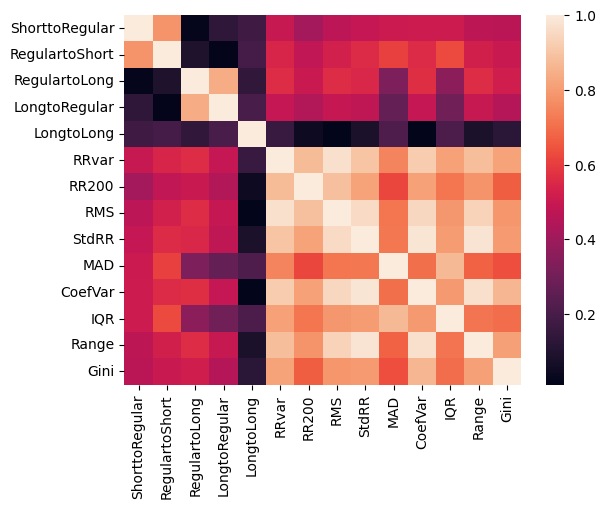

In [23]:
df_copiado = clean_df_features.copy()
df_copiado = df_copiado.drop('label',  axis=1)

# Calculamos la matriz de correlación entre las características filtradas
correlation_matrix = df_copiado.corr().abs()

# Visualizamos la matriz de correlación usando un mapa de calor
import seaborn as sns
sns.heatmap(correlation_matrix)

# Creamos una matriz con True en los elementos por encima de la diagonal principal y False en los demás
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)

# Seleccionamos solo la mitad superior de la matriz de correlación para evitar duplicados
upper_half = correlation_matrix.where(upper_triangle)

# Identificamos las columnas con una correlación mayor que un umbral dado (0.7 en este caso)
highly_correlated_features = [columna for columna in upper_half.columns if any(upper_half[columna] > 0.7)]

# Eliminamos las características altamente correlacionadas del DataFrame original filtrado
df_selected_features = df_copiado.drop(highly_correlated_features, axis=1)

In [24]:
# Características elegidas para el ML
df_selected_features.columns

Index(['ShorttoRegular', 'RegulartoLong', 'LongtoLong', 'RRvar'], dtype='object')

###Análisis de imbalanceo

In [25]:
# Vamos a ver cuantos valores hay de cada tipo
print(clean_df_features['label'].value_counts())

label
1    853
0    629
Name: count, dtype: int64


La data no está tan desbalanceada, haremos un método de balanceo SMOTE para asegurar el balanceo de la misma usando oversampling.

In [26]:
# Dividir el DataFrame en características (X) y variable objetivo (y)
X = clean_df_features.drop('label', axis=1)  # Features
y = clean_df_features['label']  # Target variable

# Aplicar SMOTE para realizar oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos balanceados
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['label'] = y_resampled

In [27]:
df_resampled['label'].value_counts()

label
0    853
1    853
Name: count, dtype: int64

In [28]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706 entries, 0 to 1705
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ShorttoRegular  1706 non-null   float64
 1   RegulartoShort  1706 non-null   float64
 2   RegulartoLong   1706 non-null   float64
 3   LongtoRegular   1706 non-null   float64
 4   LongtoLong      1706 non-null   float64
 5   RRvar           1706 non-null   float64
 6   RR200           1706 non-null   float64
 7   RMS             1706 non-null   float64
 8   StdRR           1706 non-null   float64
 9   MAD             1706 non-null   float64
 10  CoefVar         1706 non-null   float64
 11  IQR             1706 non-null   float64
 12  Range           1706 non-null   float64
 13  Gini            1706 non-null   float64
 14  label           1706 non-null   int64  
dtypes: float64(14), int64(1)
memory usage: 200.0 KB


###SVM (Support Vector Machine)

In [29]:
from sklearn.svm import SVC
import pandas.testing as tm
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score

In [30]:
# Dividimos el DataFrame en características (X) y variable objetivo (y)

#X = df_resampled.drop('label',axis=1)  # Features 1

X = df_resampled[df_selected_features.columns]  # Features

#Para con la matriz
#X = df_resampled[ ['ShorttoShort', 'ShorttoRegular', 'ShorttoLong', 'RegulartoShort', 'RegulartoRegular' , 'RegulartoLong', 'LongtoShort', 'LongtoRegular', 'LongtoLong'] ]

#Para sin la matriz
#X = df_resampled.drop( ['ShorttoShort', 'ShorttoRegular', 'ShorttoLong', 'RegulartoShort', 'RegulartoRegular', 'RegulartoLong', 'LongtoShort', 'LongtoRegular', 'LongtoLong', 'label'], axis=1)


y = df_resampled['label']  # Columna 'label' como variable objetivo

In [31]:
# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el pipeline para normalizar los datos y entrenar el SVM
pipeline = make_pipeline(StandardScaler(), SVC())

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       177
           1       0.98      0.96      0.97       165

    accuracy                           0.97       342
   macro avg       0.97      0.97      0.97       342
weighted avg       0.97      0.97      0.97       342



In [32]:
from sklearn.model_selection import GridSearchCV

# Definir el modelo
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf')) #rbf porque es el del paper que mejor resultados tiene según el paper

# Definir los hiperparámetros a buscar
param_grid = {
    'svc__C': [1, 10, 100, 1000],
    'svc__gamma': [0.001, 0.0001]
}

# Configurar el Grid Search
grid = GridSearchCV(svm_model, param_grid, refit=True, verbose=2, cv=5)

# Entrenar el modelo con los datos de entrenamiento
grid.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid.best_params_)

# Evaluar el modelo con los datos de prueba
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   0.0s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   0.0s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   0.0s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   0.0s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   0.0s
[CV] END ........................svc__C=1, svc__gamma=0.0001; total time=   0.1s
[CV] END ........................svc__C=1, svc__gamma=0.0001; total time=   0.1s
[CV] END ........................svc__C=1, svc__gamma=0.0001; total time=   0.1s
[CV] END ........................svc__C=1, svc__gamma=0.0001; total time=   0.1s
[CV] END ........................svc__C=1, svc__gamma=0.0001; total time=   0.1s
[CV] END ........................svc__C=10, svc__gamma=0.001; total time=   0.0s
[CV] END ........................svc__C=10, svc__

Con los mejores hiperparámetros:

In [33]:
pipeline2 = make_pipeline(StandardScaler(), SVC(kernel='rbf' ,C=1000, gamma=0.001))
pipeline2.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline2, X_train, y_train, cv=4)


# Predecir y evaluar el modelo
y_pred2 = pipeline2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       177
           1       0.98      0.96      0.97       165

    accuracy                           0.97       342
   macro avg       0.97      0.97      0.97       342
weighted avg       0.97      0.97      0.97       342



Métricas de rendimiento:
     Metric    Value
   Accuracy 0.970760
Sensitivity 0.963636
Specificity 0.977401
   F1 Score 0.970753

Resultados de Validación Cruzada:
 Fold    Score
    1 0.970674
    2 0.976540
    3 0.973607
    4 0.976540
Mean CV Score: 0.9743


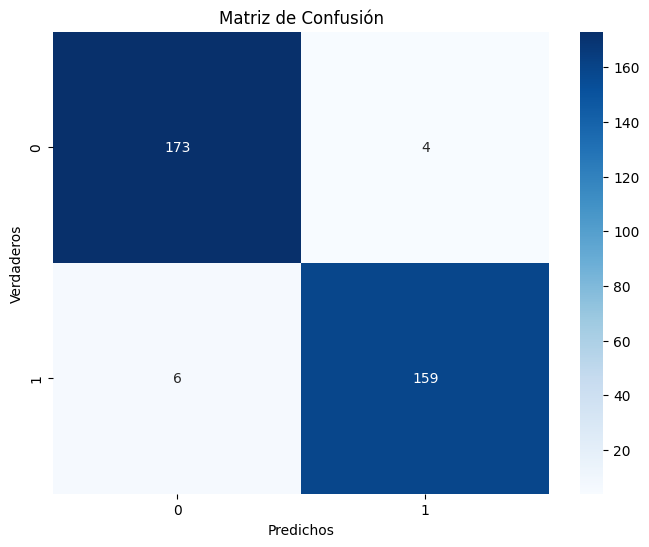

In [34]:
# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcular sensibilidad y especificidad
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Crear un DataFrame para las métricas
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score'],
    'Value': [accuracy, sensitivity, specificity, f1]
})

# Imprimir resultados
print("Métricas de rendimiento:")
print(metrics_df.to_string(index=False))

print("\nResultados de Validación Cruzada:")
cv_df = pd.DataFrame({
    'Fold': range(1, 5),
    'Score': cv_scores
})
print(cv_df.to_string(index=False))
print(f"Mean CV Score: {cv_scores.mean():.4f}")

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

In [35]:
import joblib

# Guardar el modelo entrenado
joblib_file = "modelo_entrenado.pkl"
joblib.dump(pipeline2, joblib_file)

# Descargar el archivo a tu computadora
from google.colab import files
files.download(joblib_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Análisis estadístico de las vaariables elegidas para el ML

###Ploteo de picos


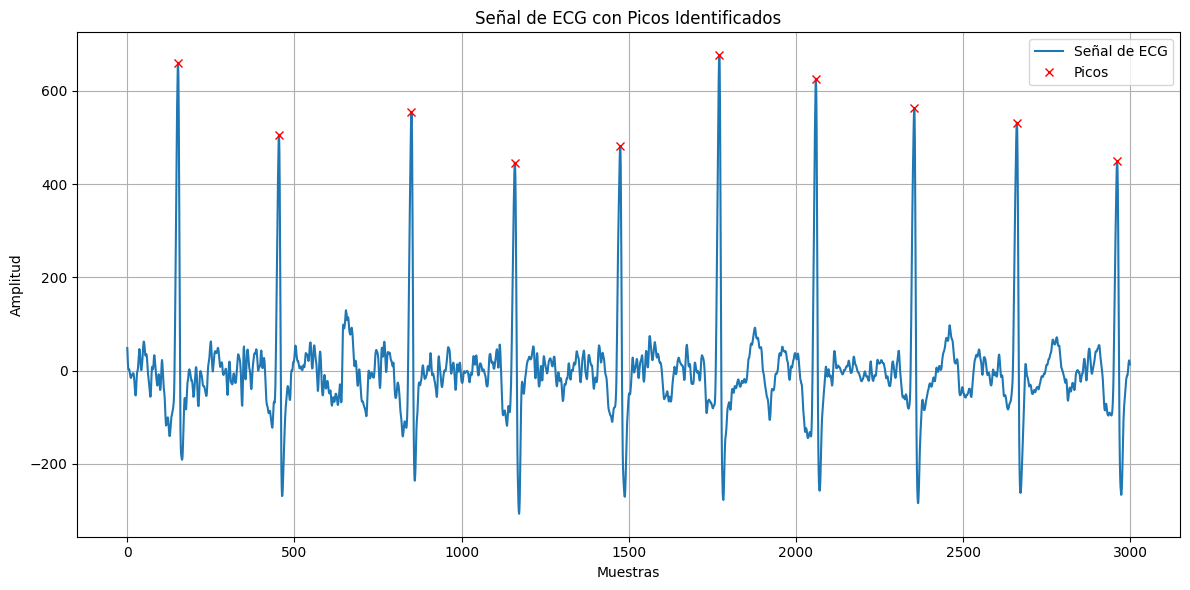

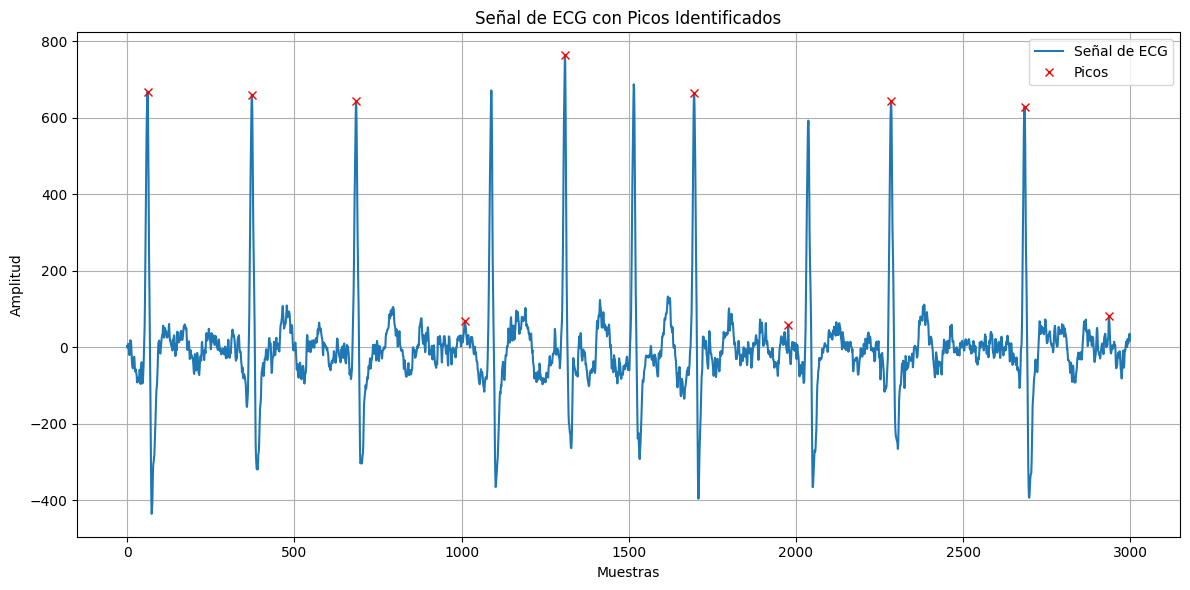

In [36]:
# Un ejemplo de paciente sano y un ejemplo de AF antes del Preprocesamiento wavelt
healthy_example_1 = filtered_X[filtered_y == 0][0]
af_example_1 = filtered_X[filtered_y == 1][0]

# Un ejemplo de paciente sano y un ejemplo de AF después del Preprocesamiento wavelt
healthy_example_2 = filtered_X_dwt[filtered_y == 0][0]
af_example_2 = filtered_X_dwt[filtered_y == 1][0]


# Función para procesar una nueva señal de ECG capturada por tu dispositivo y plotearla con los picos
def procesar_nueva_senal_y_plotear(signal):

    # Encontrar los picos en la señal preprocesada
    # peaks, _ = find_peaks(preprocessed_signal, distance=100)
    peaks, _ = find_peaks(signal, distance=500/2)


    # Plotear la señal de ECG con los picos identificados
    plt.figure(figsize=(12, 6))
    plt.plot(signal, label='Señal de ECG')
    plt.plot(peaks, signal[peaks], "x", label='Picos', color='r')
    plt.title('Señal de ECG con Picos Identificados')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return peaks

    # Ejemplo de uso con la señal capturada de la base de datos
resultado = procesar_nueva_senal_y_plotear(healthy_example_2)
resultado = procesar_nueva_senal_y_plotear(af_example_2)

